In [1]:
# librerias
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# funciones
def to_returns(prices: pd.DataFrame, method="log"):
    """Convierte precios a retornos diarios."""
    if method == "log":
        return np.log(prices).diff().dropna()
    else:
        return prices.pct_change().dropna()

def annualize_mean(r, periods_per_year=252):
    return r.mean() * periods_per_year

def annualize_vol(r, periods_per_year=252):
    return r.std() * np.sqrt(periods_per_year)

def sharpe_ratio(r, rf=0.0, periods_per_year=252):
    # rf en misma frecuencia que r (si rf anual, conviértelo antes)
    excess = r - rf
    return annualize_mean(excess, periods_per_year) / annualize_vol(r, periods_per_year)

## El mercado NO paga por riesgo diversificable

Vamos a crear un “mundo” con 3 activos correlacionados y ver qué le pasa al riesgo al diversificar.

In [4]:
np.random.seed(7)

n = 1500  # ~6 años de días hábiles
mu = np.array([0.0004, 0.00035, 0.0003])  # medias diarias
cov = np.array([
    [0.00018, 0.00012, 0.00010],
    [0.00012, 0.00020, 0.00011],
    [0.00010, 0.00011, 0.00016]
])

R = np.random.multivariate_normal(mu, cov, size=n)
rets = pd.DataFrame(R, columns=["A", "B", "C"])

print(rets.head(3))
print()
weights = np.array([1/3, 1/3, 1/3])
port = rets @ weights

print("Vol anual A:", annualize_vol(rets["A"]))
print("Vol anual B:", annualize_vol(rets["B"]))
print("Vol anual C:", annualize_vol(rets["C"]))
print("Vol anual Port(1/3):", annualize_vol(port))

          A         B         C
0 -0.022283 -0.019514 -0.015653
1 -0.009692 -0.002095 -0.001271
2 -0.011220  0.000786  0.012586

Vol anual A: 0.20770859717207285
Vol anual B: 0.22226760969368575
Vol anual C: 0.2023993748402593
Vol anual Port(1/3): 0.18135660265668666


# 2 Markowitz frontera eficiente

In [5]:
import numpy as np
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
print("Matriz A:\n", A)
print("Matriz B:\n", B)

# Producto matricial (A * B)
resultado = np.einsum('ij,jk->ik', A, B)
# Resultado: [[19, 22], [43, 50]]
print("Producto matricial A * B:\n", resultado)

Matriz A:
 [[1 2]
 [3 4]]
Matriz B:
 [[5 6]
 [7 8]]
Producto matricial A * B:
 [[19 22]
 [43 50]]


In [6]:
import numpy as np

# Define concentration parameters (e.g., 3 categories)
alpha = [10, 5, 1] 

# Generate a single sample (a vector of 3 probabilities summing to 1)
sample = np.random.dirichlet(alpha)
print("Single Sample:", sample)
print("Sum:", np.sum(sample))

# Generate 5 samples
samples = np.random.dirichlet(alpha, size=5)
for i, s in enumerate(samples):
    print(f"Sample {i+1}: {s}, Sum: {np.sum(s)}")
print("\n5 Samples:\n", samples)


Single Sample: [0.64881939 0.32585211 0.0253285 ]
Sum: 1.0
Sample 1: [0.57885548 0.32714652 0.09399799], Sum: 1.0
Sample 2: [0.63345136 0.34765217 0.01889647], Sum: 1.0
Sample 3: [0.50759168 0.45929641 0.03311191], Sum: 0.9999999999999999
Sample 4: [0.43248697 0.4764648  0.09104823], Sum: 0.9999999999999999
Sample 5: [0.76791905 0.21684488 0.01523607], Sum: 1.0

5 Samples:
 [[0.57885548 0.32714652 0.09399799]
 [0.63345136 0.34765217 0.01889647]
 [0.50759168 0.45929641 0.03311191]
 [0.43248697 0.4764648  0.09104823]
 [0.76791905 0.21684488 0.01523607]]


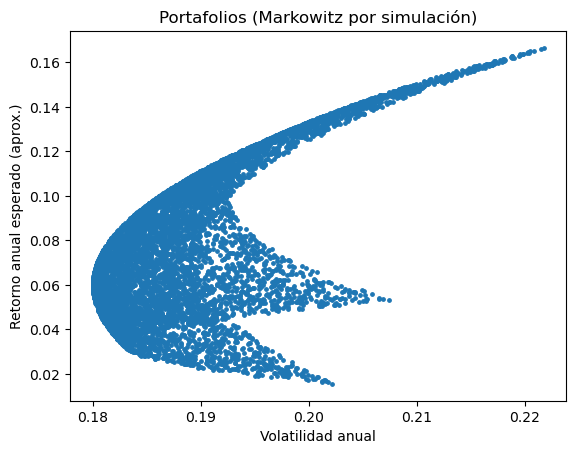

In [7]:
def random_weights(k, n_portfolios=5000):
    W = np.random.dirichlet(np.ones(k), size=n_portfolios)
    return W

def portfolio_stats(rets: pd.DataFrame, W: np.ndarray, periods_per_year=252):
    mu = rets.mean().values
    Sigma = rets.cov().values
    port_mu = W @ mu
    port_var = np.einsum('ij,jk,ik->i', W, Sigma, W)
    port_vol = np.sqrt(port_var)
    return (port_mu * periods_per_year, port_vol * np.sqrt(periods_per_year))

W = random_weights(3, n_portfolios=8000)
mu_a, vol_a = portfolio_stats(rets, W)

# Grafico portafolios
plt.figure()
plt.scatter(vol_a, mu_a, s=6)
plt.xlabel("Volatilidad anual")
plt.ylabel("Retorno anual esperado (aprox.)")
plt.title("Portafolios (Markowitz por simulación)")
plt.show()

# 3 CAPM: beta, alpha y la trampa clásica

## 3.1 Simulamos un mercado y un activo

In [8]:
np.random.seed(12)

n = 1800
mkt = np.random.normal(0.00035, 0.011, size=n)  # retorno mercado diario
rf = 0.00008  # tasa libre riesgo diaria

true_beta = 1.3
true_alpha = 0.00002  # muy pequeño
eps = np.random.normal(0, 0.014, size=n)

asset = true_alpha + true_beta * (mkt - rf) + eps

df = pd.DataFrame({
    "MKT": mkt,
    "RF": rf,
    "ASSET": asset
})

df["MKT_EXCESS"] = df["MKT"] - df["RF"]
df["ASSET_EXCESS"] = df["ASSET"] - df["RF"]
df.head(8)

,MKT,RF,ASSET,MKT_EXCESS,ASSET_EXCESS
0,0.005553,0.00008,0.034547,0.005473,0.034467
1,-0.007146,0.00008,-0.038604,-0.007226,-0.038684
2,0.003017,0.00008,-0.006279,0.002937,-0.006359
3,-0.018358,0.00008,-0.042133,-0.018438,-0.042213
4,0.008635,0.00008,0.001305,0.008555,0.001225
5,-0.016532,0.00008,-0.005275,-0.016612,-0.005355
6,0.000406,0.00008,0.014600,0.000326,0.014520
7,-0.000973,0.00008,-0.008197,-0.001053,-0.008277


## 3.2 Estimación CAPM (OLS)

In [9]:
X = sm.add_constant(df["MKT_EXCESS"])
y = df["ASSET_EXCESS"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           ASSET_EXCESS   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     1780.
Date:                Tue, 17 Feb 2026   Prob (F-statistic):          5.51e-271
Time:                        08:41:58   Log-Likelihood:                 5164.0
No. Observations:                1800   AIC:                        -1.032e+04
Df Residuals:                    1798   BIC:                        -1.031e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.562      0.5

Interpretación guiada (lo importante):

* $\beta$ (beta): sensibilidad al mercado.
* $\alpha$ (alpha): “retorno extra” no explicado por mercado (a veces suerte disfrazada).
* $Rˆ2$: qué tanto explica el mercado el activo.

## 3.3 El test de “¿alpha real o humo?”

Alpha pequeño + p-value alto = probablemente nada.

In [10]:
alpha = model.params["const"]
beta = model.params["MKT_EXCESS"]
p_alpha = model.pvalues["const"]

print("alpha diaria:", alpha)
print("beta:", beta)
print("p-value alpha:", p_alpha)

alpha diaria: -0.00018211152822443283
beta: 1.241820739730382
p-value alpha: 0.5740397574807061


## 3.4 SML (línea de mercado de valores) en versión práctica

CAPM en expectativas:

$$ E[R_i] = R_f + \beta_i(E[R_m]-R_f) $$

In [11]:
# estimamos primas anuales con nuesrtras medias muestrales
Erm = annualize_mean(df["MKT"])
Erf = annualize_mean(df["RF"])
capm_return = Erf + beta * (Erm - Erf)

print("E[Rm] anual:", Erm)
print("Rf anual:", Erf)
print("E[Ri] CAPM anual:", capm_return)
print("E[Ri] muestral anual:", annualize_mean(df["ASSET"]))

E[Rm] anual: -0.0031995449082992443
Rf anual: 0.02016
E[Ri] CAPM anual: -0.008848367337789244
E[Ri] muestral anual: -0.05474047245034637


	• Si el CAPM “no cuadra” no significa que no sirva el modelo.
	• Significa que revises: ventana temporal, estabilidad, regime change, datos, etc.

# Data Real

In [12]:
import yfinance as yf

tickers = ["AAPL", "MSFT", "GOOGL"]
data = yf.download(tickers, start="2025-01-01", end="2025-12-31", progress=False)["Close"]
rets = to_returns(data)
print(rets.head(3))

weights = np.array([1/3, 1/3, 1/3])
port = rets @ weights
print()
print(f"Vol anual {tickers[0]}:", annualize_vol(rets[tickers[0]]))
print(f"Vol anual {tickers[1]}:", annualize_vol(rets[tickers[1]]))
print(f"Vol anual {tickers[2]}:", annualize_vol(rets[tickers[2]]))
print(f"Vol anual Port(1/3):", annualize_vol(port))

Ticker          AAPL     GOOGL      MSFT
Date                                    
2025-01-03 -0.002012  0.012381  0.011331
2025-01-06  0.006716  0.026143  0.010573
2025-01-07 -0.011453 -0.007034 -0.012891

Vol anual AAPL: 0.32224533065007244
Vol anual MSFT: 0.2410367821337261
Vol anual GOOGL: 0.3233684762772588
Vol anual Port(1/3): 0.23777307470694486


In [13]:
print(f"Mean anual {tickers[0]}:", annualize_mean(rets[tickers[0]]))
print(f"Mean anual {tickers[1]}:", annualize_mean(rets[tickers[1]]))
print(f"Mean anual {tickers[2]}:", annualize_mean(rets[tickers[2]]))
print(f"Mean anual Port(1/3):", annualize_mean(port))

Mean anual AAPL: 0.11962280000741911
Mean anual MSFT: 0.1623072832665029
Mean anual GOOGL: 0.5170109816513784
Mean anual Port(1/3): 0.26631368830843344


In [21]:
print(f"Sharpe anual {tickers[0]}:", annualize_mean(rets[tickers[0]]) / annualize_vol(rets[tickers[0]]))
print(f"Sharpe anual {tickers[1]}:", annualize_mean(rets[tickers[1]]) / annualize_vol(rets[tickers[1]]))
print(f"Sharpe anual {tickers[2]}:", annualize_mean(rets[tickers[2]]) / annualize_vol(rets[tickers[2]]))
print(f"Sharpe anual Port(1/3):", annualize_mean(port) / annualize_vol(port))

Sharpe anual AAPL: 0.37121651660912464
Sharpe anual MSFT: 0.6733714444055198
Sharpe anual GOOGL: 1.5988286819766877
Sharpe anual Port(1/3): 1.1200328806045619


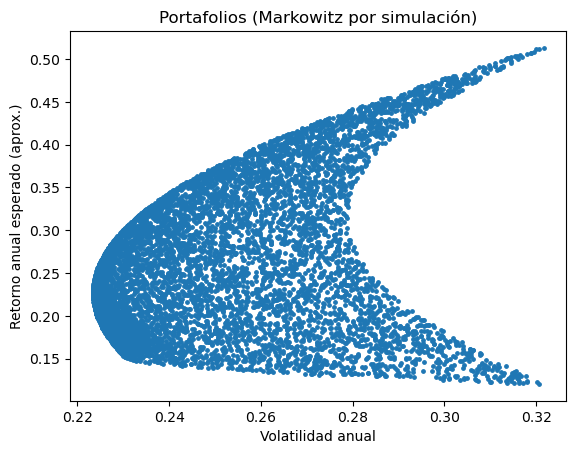

In [14]:
W = random_weights(3, n_portfolios=8000)
mu_a, vol_a = portfolio_stats(rets, W)

plt.figure()
plt.scatter(vol_a, mu_a, s=6)
plt.xlabel("Volatilidad anual")
plt.ylabel("Retorno anual esperado (aprox.)")
plt.title("Portafolios (Markowitz por simulación)")
plt.show()

In [ ]:
tickers = ["AAPL", "MSFT", "GOOGL", "SPY"]
data = yf.download(tickers, start="2025-01-01", end="2025-12-31", progress=False)["Close"]
rets = to_returns(data)

benchmark = "SPY"
data_bench = yf.download(benchmark, start="2025-01-01", end="2025-12-31", progress=False)["Close"]
rets_bench = to_returns(data_bench)

In [16]:
from scipy.stats import linregress

returns_benchmark = rets["SPY"].values
slope, intercept, r_value, p_value, std_err  = linregress(returns_benchmark, rets["AAPL"].values)
alpha = np.round(intercept, 4)
beta = np.round(slope, 4)
null_hypothesis = p_value > 0.05 # p_value < 0.05 --> reject null hypothesis
r_squared = np.round(r_value**2, 4)
correlation = r_value
predictor_linreg = alpha + beta*returns_benchmark

print(f"AAPL - Beta: {beta}, Alpha diaria: {alpha}, p-value alpha: {p_value:.4f}, correlation: {correlation:.4f}, R^2: {r_squared:.4f}")


AAPL - Beta: 1.2445, Alpha diaria: -0.0004, p-value alpha: 0.0000, correlation: 0.7486, R^2: 0.5604


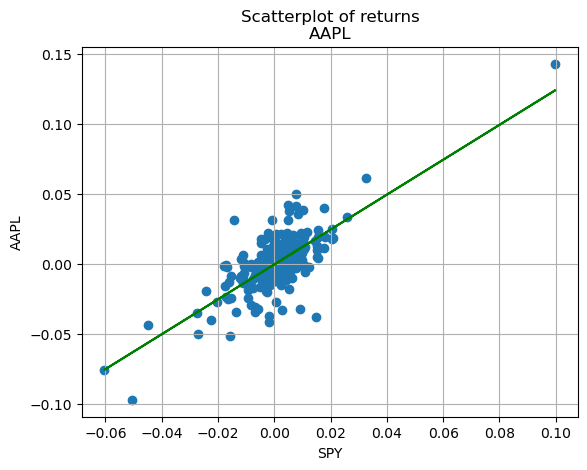

In [17]:
str_title = 'Scatterplot of returns' + '\n' + tickers[0]
plt.figure()
plt.title(str_title)
plt.scatter(returns_benchmark, rets["AAPL"].values)
plt.plot(returns_benchmark, predictor_linreg, color='green')
plt.ylabel(tickers[0])
plt.xlabel(tickers[-1])
plt.grid()
plt.show()

In [18]:
X = sm.add_constant(returns_benchmark)
y = rets["AAPL"].values

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     313.6
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           8.42e-46
Time:                        08:44:35   Log-Likelihood:                 717.02
No. Observations:                 248   AIC:                            -1430.
Df Residuals:                     246   BIC:                            -1423.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.459      0.6

In [19]:
returns_benchmark = rets["SPY"].values
for ticker in tickers[:-1]:  # excluimos SPY
    returns_asset = rets[ticker].values
    slope, intercept, r_value, p_value, std_err = linregress(returns_benchmark, returns_asset)
    print(f"{ticker} - Beta: {slope:.4f}, Alpha diaria: {intercept:.6f}, p-value alpha: {p_value:.4f}, correlation: {r_value:.4f}, R^2: {r_value**2:.4f}")


AAPL - Beta: 1.2445, Alpha diaria: -0.000394, p-value alpha: 0.0000, correlation: 0.7486, R^2: 0.5604
MSFT - Beta: 0.8680, Alpha diaria: 0.000038, p-value alpha: 0.0000, correlation: 0.6981, R^2: 0.4873
GOOGL - Beta: 1.0318, Alpha diaria: 0.001332, p-value alpha: 0.0000, correlation: 0.6185, R^2: 0.3825


## 3.6 Portafolio de betas maximizando con sharpe ratio

Supongamos que tenemos un portafolio $P$ conformado por $n$ activos. La beta de dicho portafolio estará determinada por

$$\beta_P = \sum_{i=1}^n w_i * \beta_i$$

donde $\beta_i$ es la beta del activo $i$ en el portafolio y $w_i$ es el peso del activo $i$ dentro del portafolio.

El Sharpe ratio se define como

$$\dfrac{r_p-r_f}{\sigma_p}$$

In [59]:
rets.head(3)

Ticker,AAPL,GOOGL,MSFT,SPY
Date,,,,
2025-01-03,-0.002012,0.012381,0.011331,0.012426
2025-01-06,0.006716,0.026143,0.010573,0.005744
2025-01-07,-0.011453,-0.007034,-0.012891,-0.011368


In [60]:
# function compute beta
def compute_beta(returns_asset, returns_benchmark):
    beta, alpha, r_value, p_value, std_err = linregress(returns_benchmark, returns_asset)
    return beta, alpha

compute_beta(rets["AAPL"].values, rets["SPY"].values)

(1.244494332171737, -0.000393578488656457)

In [61]:
# function beta portfolio
    
def compute_portfolio_beta(weights, betas):
    return np.dot(weights, betas)

In [69]:
tickers[:-1]

['AAPL', 'MSFT', 'GOOGL']

In [72]:
betas_portfolio = []
for ticker in tickers[:-1]:  # excluimos SPY
    # print(f"Calculando beta para {ticker}...")
    beta ,_ = compute_beta(rets[ticker].values, rets['SPY'].values)
    betas_portfolio.append(beta)
    print(f"Beta {ticker}: {beta:.4f}")

Beta AAPL: 1.2445
Beta MSFT: 0.8680
Beta GOOGL: 1.0318


In [73]:
print("\nBetas del portafolio:")
compute_portfolio_beta(weights, betas_portfolio)


Betas del portafolio:


1.0480877776314839

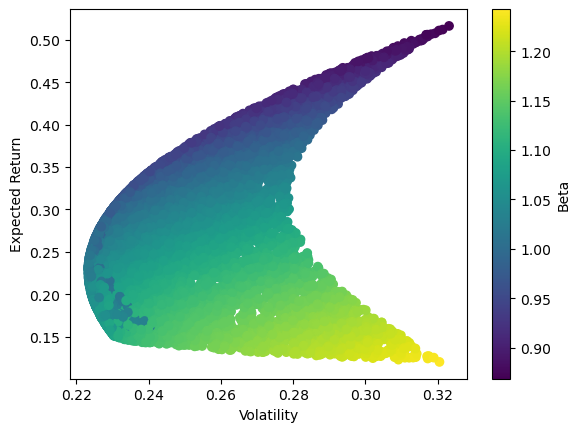

In [79]:
W = random_weights(3, n_portfolios=8000)
betas_portafolios = W @ np.array(betas_portfolio)
mu_a, vol_a = portfolio_stats(rets.iloc[:, :-1], W)

plt.scatter(vol_a, mu_a, c=betas_portafolios, cmap='viridis')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Beta')
plt.show()

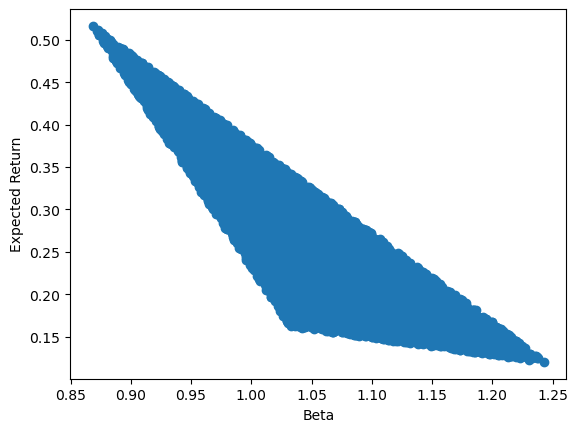

In [82]:
plt.scatter(betas_portafolios, mu_a, )
plt.xlabel('Beta')
plt.ylabel('Expected Return')
plt.show()

## 3.7 CAPM Cobertura

In [84]:
tickers = ["NVDA", "SPY"]
data = yf.download(tickers, start="2025-01-01", end="2025-12-31", progress=False)["Close"]
rets = to_returns(data)
rets.head(3)

beta, alpha = compute_beta(rets["NVDA"].values, rets["SPY"].values)
print(f"Beta NVDA: {beta:.4f}, Alpha diaria: {alpha:.6f}")

Beta NVDA: 1.8732, Alpha diaria: -0.000078


Supongamos que tenemos invertidos $100,000 ´SPY´ y queremos cubrir esta posición. Si lo quisieramos hacer de manera "natural" con ´NVDA´ tendríamos que ir cortos con $100,000 en ´NVDA´, sin embargo esto no garantiza una cobertura robusta, ya que si ´SPY´ sube 1\% ganaríamos $1,000 pero de acuerdo al CAPM con ´NVDA´ perderíamos $1,800 aprox. (**Cobertura delta neutral**)
Si baja el ´SPY´ 1\% perderíamos $1,000 pero ganaríamos $1,800 aprox. con ´NVDA´.

Para robustecer esta cobertura podemos considerar las betas para equilibar el riesgo y el monto a invertir.

In [86]:
tickers = ["NVDA", "MSFT" , "META", "SPY"]
data = yf.download(tickers, start="2025-01-01", end="2025-12-31", progress=False)["Close"]
rets = to_returns(data)
rets.head(3)

beta, alpha = compute_beta(rets["NVDA"].values, rets["SPY"].values)
print(f"Beta NVDA: {beta:.4f}, Alpha diaria: {alpha:.6f}")

beta, alpha = compute_beta(rets["MSFT"].values, rets["SPY"].values)
print(f"Beta MSFT: {beta:.4f}, Alpha diaria: {alpha:.6f}")

beta, alpha = compute_beta(rets["META"].values, rets["SPY"].values)
print(f"Beta META: {beta:.4f}, Alpha diaria: {alpha:.6f}")

Beta NVDA: 1.8732, Alpha diaria: -0.000078
Beta MSFT: 0.8680, Alpha diaria: 0.000038
Beta META: 1.3829, Alpha diaria: -0.000527


Imaginemos que estamos invertidos con $100,000 en ´META´ (activo $S_0$) y queremos cubrir la posición con ´NVDA´ (activo $S_1$) y ´MSFT´ (activo $S_2$). Entonces podemos establecer el siguiente sistema de ecuaciones para encontrar el monto a invertir en ´NVDA´ y ´MSFT´:

$$S_0 + S_1 + S_2 = 0, \text{cobertura delta neutral} $$

$$\beta_0 S_0 + \beta_1 S_1 + \beta_2 S_2 = 0, \text{cobertura beta neutral} $$

$$
\begin{pmatrix}
  1 & 1  \\
  \beta_1 & \beta_2 \\
\end{pmatrix}
\begin{pmatrix} S_1\\ S_2\\ \end{pmatrix} = \begin{pmatrix} -S_0\\ -\beta_0 S_0\\ \end{pmatrix}
$$

$$ \therefore
\begin{pmatrix} S_1\\ S_2\\ \end{pmatrix} = \begin{pmatrix}
  1 & 1  \\
  \beta_1 & \beta_2 \\
\end{pmatrix}^{-1}
\begin{pmatrix} -S_0\\ -\beta_0 S_0\\ \end{pmatrix}
$$

In [87]:
ric = 'META' #'REP.MC' #'ba' #BBVA.MC
benchmark = 'SPY'  #  'SPY'   '^STOXX'
hedge_rics = ['NVDA', 'MSFT']
delta = 10  #10 M usd
tickers = [ric] + hedge_rics + [benchmark]

data = yf.download(tickers, start="2025-01-01", end="2025-12-31", progress=False)["Close"]
rets = to_returns(data)

In [88]:
beta = compute_beta(rets[ric].values, rets[benchmark].values)[0]
beta_usd = beta * delta
print(f"Beta {ric}: {beta:.4f}, Beta en USD: {beta_usd:.2f}")

Beta META: 1.3829, Beta en USD: 13.83


In [91]:
betas = [compute_beta(rets[hedge_ric].values, rets[benchmark].values)[0] \
                        for hedge_ric in hedge_rics]
print("Betas hedge:", betas)

Betas hedge: [1.873239839534285, 0.8680129677681336]


In [92]:
betas = np.asarray(betas).reshape([len(hedge_rics),1])

dataframe = pd.DataFrame()
dataframe['ric'] = hedge_rics
dataframe['beta'] = betas

print('------')
print('Input portfolio:')
print('Delta mnUSD for ' + ric + ' is ' + str(delta))
print('Beta for ' + ric + ' vs ' + benchmark + ' is ' + str(beta))
print('Beta mnUSD for ' + ric + ' vs ' + benchmark + ' is ' + str(beta_usd))
print('------')
print('Input hedges:')
for n in range(dataframe.shape[0]):
    print('Beta for hedge[' + str(n) + '] = ' + dataframe['ric'][n] \
          + ' vs ' + benchmark + ' is ' + str(dataframe['beta'][n]))

------
Input portfolio:
Delta mnUSD for META is 10
Beta for META vs SPY is 1.382935878622197
Beta mnUSD for META vs SPY is 13.82935878622197
------
Input hedges:
Beta for hedge[0] = NVDA vs SPY is 1.873239839534285
Beta for hedge[1] = MSFT vs SPY is 0.8680129677681336


In [95]:
print(dataframe)
print(dataframe.shape)
np.ones([3,2])

    ric      beta
0  NVDA  1.873240
1  MSFT  0.868013
(2, 2)


array([[1., 1.],
       [1., 1.],
       [1., 1.]])

$$ \therefore
\begin{pmatrix} S_1\\ S_2\\ \end{pmatrix} = \begin{pmatrix}
  1 & 1  \\
  \beta_1 & \beta_2 \\
\end{pmatrix}^{-1}
\begin{pmatrix} -S_0\\ -\beta_0 S_0\\ \end{pmatrix}
$$

In [ ]:
size = dataframe.shape[0] # numero de activos para la cobertura
deltas = np.ones([size,1]) # vector columna de deltas (1 por cada activo de la cobertura)
targets = -np.array([[delta],[beta_usd]]) # vector a cubrir (delta y beta en USD)
mtx = np.transpose(np.column_stack((deltas, betas))) # matrix a invertir
optimal_hedge = np.linalg.inv(mtx).dot(targets) # solucion del sistema de ecuaciones para encontrar los pesos de la cobertura
dataframe['delta'] = optimal_hedge # cantidad a invertir en cada activo de la cobertura
dataframe['beta_usd'] = betas*optimal_hedge # beta en USD para cada activo de la cobertura
hedge_delta = np.sum(dataframe['delta'])
hedge_beta_usd = np.sum(dataframe['beta_usd']) #np.transpose(betas).dot(optimal_hedge).item()

In [99]:
print('------')
print(str(ric))
# print('Optimisation result | ' + optimisation_type + ':')
print('Optimisation result :')
print('------')
print('Delta: ' + str(delta))
print('Beta USD: ' + str(beta_usd))
print('------')
print('Hedge delta: ' + str(hedge_delta))
print('Hedge beta USD: ' + str(hedge_beta_usd))
print('------')
print('Betas for the hedge:')
print(betas)
print('------')
print('Hegde rics:')
print(hedge_rics)
print('Optimal hedge:')
print(optimal_hedge)

------
META
Optimisation result :
------
Delta: 10
Beta USD: 13.82935878622197
------
Hedge delta: -9.999999999999998
Hedge beta USD: -13.829358786221967
------
Betas for the hedge:
[[1.87323984]
 [0.86801297]]
------
Hegde rics:
['NVDA', 'MSFT']
Optimal hedge:
[[-5.12245469]
 [-4.87754531]]


In [ ]:
def cobertura():

In [100]:
ric = 'META' #'REP.MC' #'ba' #BBVA.MC
benchmark = 'SPY'  #  'SPY'   '^STOXX'
hedge_rics = ['NVDA', 'MSFT', 'JPM']
delta = 10  #10 M usd
tickers = [ric] + hedge_rics + [benchmark]

data = yf.download(tickers, start="2025-01-01", end="2025-12-31", progress=False)["Close"]
rets = to_returns(data)

beta = compute_beta(rets[ric].values, rets[benchmark].values)[0]
beta_usd = beta * delta
print(f"Beta {ric}: {beta:.4f}, Beta en USD: {beta_usd:.2f}, \n")

betas = [compute_beta(rets[hedge_ric].values, rets[benchmark].values)[0] \
                        for hedge_ric in hedge_rics]
print("Betas hedge:", betas, "\n")

Beta META: 1.3829, Beta en USD: 13.83, 

Betas hedge: [1.873239839534285, 0.8680129677681336, 0.9606697099784456] 



In [102]:
from scipy.optimize import minimize

def cost_function_beta_delta(x, delta, beta_usd, betas, epsilon=0.0):
    f_delta = (sum(x).item() + delta)**2
    y = x.T
    f_beta = (np.transpose(betas).dot(y).item() + beta_usd)**2
    f_penalty = epsilon * sum(x**2).item()
    f = f_delta + f_beta + f_penalty
    return f

epsilon=0.01
x = np.zeros([len(betas),])
args = (delta, beta_usd, betas, epsilon)
optimal_result = minimize(fun = cost_function_beta_delta,\
                          x0=x, args=args, method='BFGS')

optimal_hedge = optimal_result.x.tolist()

df = pd.DataFrame()

df['rics hedge'] = hedge_rics
df['beta'] = betas
df['delta'] = optimal_hedge
df['beta_usd'] = np.array(betas) *optimal_result.x
hedge_delta = np.sum(df['delta'])
hedge_beta_usd = np.sum(df['beta_usd'])

df.head(len(hedge_rics))

,rics hedge,beta,delta,beta_usd
0,NVDA,1.873240,-4.855029,-9.094634
1,MSFT,0.868013,-2.460152,-2.135443
2,JPM,0.960670,-2.680897,-2.575457


In [103]:
print('------')
# print('Optimisation result | ' + optimisation_type + ':')
print('Optimisation result :')
print('------')
print('Delta: ' + str(delta))
print('Beta USD: ' + str(beta_usd))
print('------')
print('Hedge delta: ' + str(hedge_delta))
print('Hedge beta USD: ' + str(hedge_beta_usd))
print('------')
print('Betas for the hedge:')
print(betas)
print('------')
print('Hegde rics:')
print(hedge_rics)

print('Optimal hedge:')
print(optimal_hedge)

------
Optimisation result :
------
Delta: 10
Beta USD: 13.82935878622197
------
Hedge delta: -9.996078273639561
Hedge beta USD: -13.805534630023054
------
Betas for the hedge:
[1.873239839534285, 0.8680129677681336, 0.9606697099784456]
------
Hegde rics:
['NVDA', 'MSFT', 'JPM']
Optimal hedge:
[-4.855029222156701, -2.46015159673577, -2.680897454747091]


# 4 Modelos multifactor: cuando una beta no alcanza

## 4.1 Creamos factores “estilo”

Ejemplo típico: mercado + tamaño + valor + momentum (toy model).

In [104]:
np.random.seed(21)

n = 1800
mkt = np.random.normal(0.00035, 0.011, size=n)
smb = np.random.normal(0.00010, 0.006, size=n)   # size
hml = np.random.normal(0.00008, 0.006, size=n)   # value
mom = np.random.normal(0.00012, 0.007, size=n)   # momentum
rf  = np.full(n, 0.00008)

# Activo con exposición a varios factores
b = {"mkt": 1.1, "smb": 0.4, "hml": -0.2, "mom": 0.5}
alpha_true = 0.00001
eps = np.random.normal(0, 0.013, size=n)

asset = alpha_true + b["mkt"]*(mkt-rf) + b["smb"]*smb + b["hml"]*hml + b["mom"]*mom + eps

df2 = pd.DataFrame({
    "RF": rf,
    "MKT_EXCESS": mkt-rf,
    "SMB": smb,
    "HML": hml,
    "MOM": mom,
    "ASSET_EXCESS": asset-rf
})

print(df2.head(3))

        RF  MKT_EXCESS       SMB       HML       MOM  ASSET_EXCESS
0  0.00008   -0.000302  0.000588  0.012697  0.007610     -0.006433
1  0.00008   -0.000953 -0.006698  0.011082  0.002145      0.004347
2  0.00008    0.011730  0.007269  0.000101  0.005323     -0.013015


In [105]:
# CAPM
X1 = sm.add_constant(df2[["MKT_EXCESS"]])
capm = sm.OLS(df2["ASSET_EXCESS"], X1).fit()

# Multifactor
Xk = sm.add_constant(df2[["MKT_EXCESS","SMB","HML","MOM"]])
mf = sm.OLS(df2["ASSET_EXCESS"], Xk).fit()

print("CAPM R2:", capm.rsquared)
print("MF   R2:", mf.rsquared)
print("\nCAPM params:\n", capm.params)
print("\nMF params:\n", mf.params)


CAPM R2: 0.4323347047656776
MF   R2: 0.48857607162764793

CAPM params:
 const         0.000394
MKT_EXCESS    1.080469
dtype: float64

MF params:
 const         0.000224
MKT_EXCESS    1.080326
SMB           0.405706
HML          -0.240493
MOM           0.458014
dtype: float64


In [106]:
def summarize_model(m):
    out = pd.DataFrame({
        "coef": m.params,
        "pval": m.pvalues
    })
    return out, m.rsquared

capm_table, capm_r2 = summarize_model(capm)
mf_table, mf_r2 = summarize_model(mf)

print("CAPM R2:", capm_r2)
display(capm_table)

print("MF R2:", mf_r2)
display(mf_table)


CAPM R2: 0.4323347047656776


,coef,pval
const,0.000394,2.165792e-01
MKT_EXCESS,1.080469,2.428152e-223


MF R2: 0.48857607162764793


,coef,pval
const,0.000224,4.614298e-01
MKT_EXCESS,1.080326,1.056550e-240
SMB,0.405706,3.969884e-15
HML,-0.240493,9.750529e-07
MOM,0.458014,5.877095e-26


In [108]:

tickers = ["AAPL", "MSFT", "^GSPC"]  # activo(s) + mercado
data = yf.download(tickers, start="2018-01-01", progress=False)["Close"].dropna()

rets = to_returns(data, method="log")
asset = rets["AAPL"]
mkt = rets["^GSPC"]

# Proxy RF simple (mejor: usar T-bills o FRED; aquí usamos 0 para demo)
rf = 0.0

df = pd.DataFrame({
    "ASSET_EXCESS": asset - rf,
    "MKT_EXCESS": mkt - rf
}).dropna()

X = sm.add_constant(df["MKT_EXCESS"])
capm_real = sm.OLS(df["ASSET_EXCESS"], X).fit()
print(capm_real.summary())


                            OLS Regression Results                            
Dep. Variable:           ASSET_EXCESS   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     2993.
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        11:28:26   Log-Likelihood:                 6078.4
No. Observations:                2041   AIC:                        -1.215e+04
Df Residuals:                    2039   BIC:                        -1.214e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.336      0.1